#  Изменение цен акций после больших отклонений от своих исторических максимумов

Мы хотим проанализировать как изменялась цена акций после больших отклонений от своих исторических максимумов.

In [74]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from datetime import date

## Считываем дынные исторических цен акций

In [75]:
str1 = []
folder = []
All_Secs_list = []
strings_counter_list = []

for i in os.walk('D:\Торговля\Код\Анализ 7000 Акций США\Пример_1'):   # Путь к папке с файлами котировок!!!
    folder.append(i)

stocks_counter = 0
for address, dirs, files in folder:         # Проходим по всем файлам акций в папке подвыборки
    for file in files:
        my_file = open(address+'/'+file, mode= "r")
        sec = pd.read_csv(my_file)
        sec = np.array(sec)
        All_Secs_list.append(sec)
        my_file.close()
        
All_Secs = np.array(All_Secs_list)     
stocks_count = All_Secs.shape[0]
print('stocks_count: ', stocks_count)

stocks_count:  600


C:\Users\user\AppData\Local\Temp\ipykernel_4356\2535834543.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  All_Secs = np.array(All_Secs_list)


## Проходим по всем вариантам отклонений и времени выхода и записываем результаты сделок.

In [82]:
otkl_min = 10
otkl_max = 95
otkl_step = 5

vihod_min = 10
vihod_max = 250
vihod_step = 10
vihod_length = range(vihod_min, vihod_max,vihod_step)

counter = 0
stopper = False
write_results_by_otkl = False
results_by_secs = []
for k in range(0, stocks_count):
    results_by_otkl = []
    current_sec = np.array(All_Secs[k])
    days_count = current_sec.shape[0] - 1
    best_price = 0
    exitFlag=False
    if days_count < vihod_max + 1:           # Если дней котировок акции меньше vihod_max, то пропускаем.
        next                                 
        
    for otkl in range(otkl_min, otkl_max + 1, otkl_step):      # Перебираем различные отклонения
        stopper = False
        comulative_results_by_vihod = np.zeros(int((vihod_max - vihod_min)/vihod_step + 1))
        divider = 0
        for i in range(1, days_count + 1 - vihod_max):
            current_price = float(current_sec[i,1])
            if i == 1:
                best_price = current_price
                stopper = False
            if current_price > best_price:
                best_price = current_price
                stopper = False
            if current_price < float(current_sec[i-1,1])*0.57: # Фильтр от дробления (сплитов)
                best_price = current_price
                stopper = False
            if best_price > 0:
                my_string = current_sec[i,0]
                year = int(my_string[0:4])
                if year != 2008 and year != 2009:            # Убираем 2008 и 2009 года потому что они дают оч хорош результат
                    if (best_price - current_price) / best_price * 100 > otkl and stopper == False:
                        counter = counter + 1
                        stopper = True
                        results_by_vihod = []
                        for l in range(vihod_min, vihod_max + 1, vihod_step):   # Перебор дней до выхода  
                            later_price = float(current_sec[i + l, 1])
                            current_result = (later_price - current_price)/current_price * 100
                            if current_result < 400:
                                results_by_vihod.append(current_result)       #Фильтр для слишком больших выбросов
                            else:
                                results_by_vihod.append(0)
                        
                        comulative_results_by_vihod = comulative_results_by_vihod + np.array(results_by_vihod)
                        divider = divider + 1
                        write_results_by_otkl = True     # Добавлено чтобы не записывать когда нет сделок в просматриваемой акции
                    
        if write_results_by_otkl == True:     
            comulative_results_by_vihod = comulative_results_by_vihod / divider
            results_by_otkl.append(comulative_results_by_vihod)
        write_results_by_otkl = False
        
    results_by_secs.append(np.array(results_by_otkl))
    
results_by_secs = np.array(results_by_secs)
    
secs_num = results_by_secs.shape[0] 

C:\Users\user\AppData\Local\Temp\ipykernel_4356\688336285.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_by_secs = np.array(results_by_secs)


## Анализ результатов сделок

In [78]:
deals_profit = np.zeros((int((otkl_max - otkl_min) / otkl_step + 1), int((vihod_max - vihod_min) / vihod_step + 1)))
deals_loss = np.zeros((int((otkl_max - otkl_min) / otkl_step + 1), int((vihod_max - vihod_min) / vihod_step + 1)))
deals_count = np.zeros((int((otkl_max - otkl_min) / otkl_step + 1), int((vihod_max - vihod_min) / vihod_step + 1)))             

      
for i in range(0, secs_num):
    for j in range(0, int((otkl_max - otkl_min) / otkl_step + 1)):
        if j >= results_by_secs[i].shape[0]:
            break
        for k in range(0, int((vihod_max - vihod_min) / vihod_step + 1)):
            if results_by_secs[i][j][k] >= 0 and results_by_secs[i][j][k] < 400:   # Фильтр от возможных выбросов
                deals_profit[j][k] = deals_profit[j][k] + results_by_secs[i][j][k]
                deals_count[j][k] = deals_count[j][k] + 1
            if results_by_secs[i][j][k] < 0:
                deals_loss[j][k] = deals_loss[j][k] + results_by_secs[i][j][k]
                deals_count[j][k] = deals_count[j][k] + 1
         

overal_profit = deals_profit + deals_loss
mean_profit = overal_profit / deals_count
P_E = -deals_profit / deals_loss

otkl_list = np.arange(otkl_min, otkl_max + 1, otkl_step)
vihod_list = np.arange(vihod_min, vihod_max + 1, vihod_step) 

deals_loss = np.transpose(deals_loss)
deals_loss = pd.DataFrame(deals_loss)
deals_loss.columns = [otkl_list]

deals_profit = np.transpose(deals_profit)
deals_profit = pd.DataFrame(deals_profit)
deals_profit.columns = [otkl_list]

mean_profit = np.transpose(mean_profit)
mean_profit = pd.DataFrame(mean_profit)
mean_profit.columns = [otkl_list]

overal_profit = np.transpose(overal_profit)
overal_profit = pd.DataFrame(overal_profit)
overal_profit.columns = [otkl_list]

P_E = np.transpose(P_E)
P_E = pd.DataFrame(P_E)
P_E.columns = [otkl_list]

deals_count = np.transpose(deals_count)
deals_count = pd.DataFrame(deals_count)
deals_count.columns = [otkl_list]


'''
print('mean_profit:')
print(mean_profit)
print('P_E:')
print(P_E)
print('deals_count:')
print(deals_count)
print('counter:')
print(counter)
print('overal_profit:')
print(overal_profit)
'''

All_Max:
mean_profit:
          10        15        20        25        30        35        40  \
0   0.489870  1.047411  1.923354  1.999941  1.825261  2.750606  2.985349   
1   0.135193  0.464842  1.395532  2.083320  2.143993  2.825533  3.754306   
2   0.213853  0.976706  1.630141  2.110828  2.999147  3.845903  3.707910   
3   0.573346  1.024205  1.677750  2.121904  3.367723  4.166597  4.825691   
4   0.538575  1.474937  2.215262  2.780432  3.851518  5.175634  5.770891   
5   0.834567  1.636537  2.536323  3.012890  4.357403  5.735953  6.176636   
6   1.033298  1.981793  3.062495  3.397658  4.554316  6.756301  6.980148   
7   0.925884  1.959501  2.907661  2.977704  3.858540  5.798608  5.395721   
8   1.048104  1.834468  2.719830  2.696472  3.029024  5.377717  4.860758   
9   0.640372  1.374775  1.756339  1.352704  2.100024  3.864569  3.329518   
10  0.259365  0.949171  1.355633  1.183186  1.452331  2.755209  2.411939   
11  0.362051  0.799542  1.473366  1.266781  1.328361  3.166382  2.

<AxesSubplot:xlabel='None'>

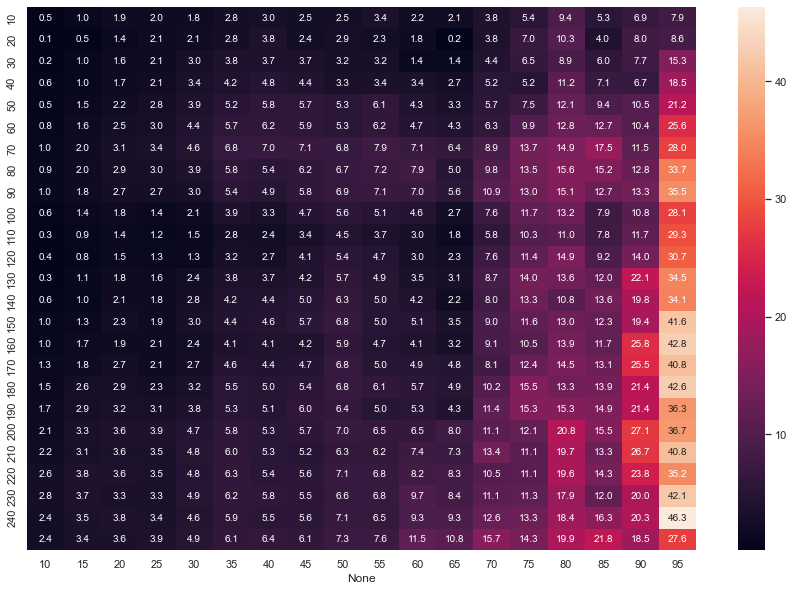

In [79]:
plt.rcParams['figure.figsize'] = 15, 10
sns.heatmap(mean_profit, annot=True, fmt=".1f", xticklabels = True, yticklabels = vihod_length)

<AxesSubplot:xlabel='None'>

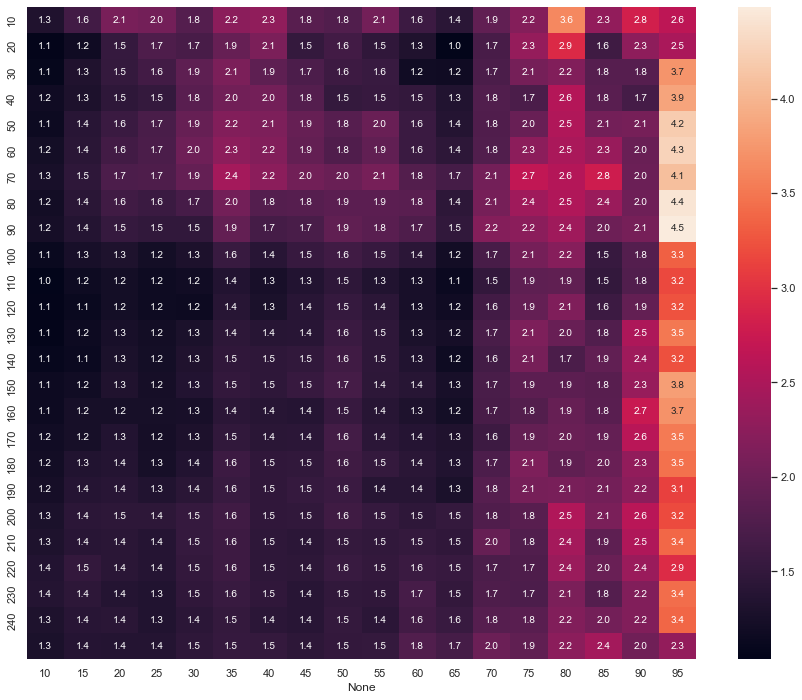

In [80]:
plt.rcParams['figure.figsize'] = 15, 12
sns.heatmap(P_E, annot=True, fmt=".1f", xticklabels = True, yticklabels = vihod_length)

<AxesSubplot:xlabel='None'>

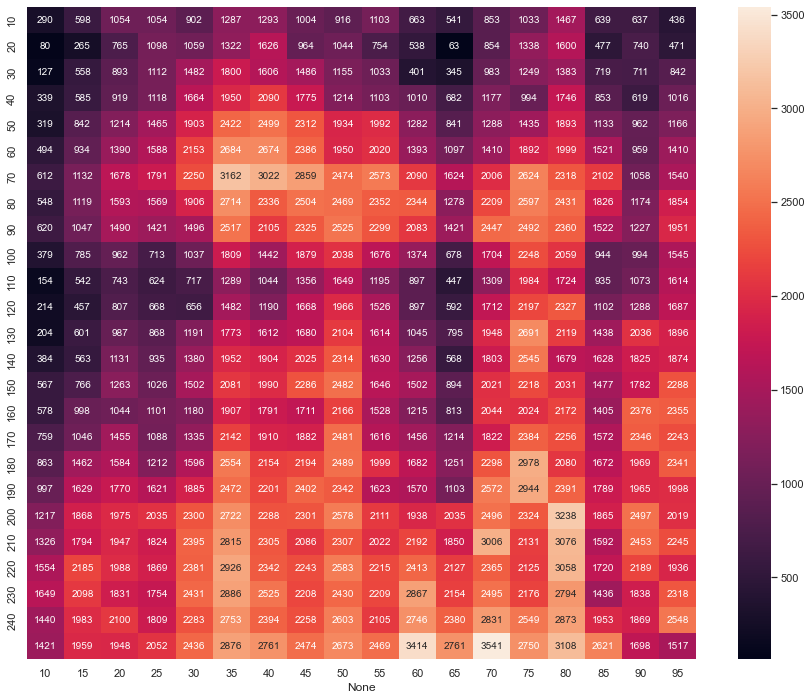

In [81]:
plt.rcParams['figure.figsize'] = 15, 12
sns.heatmap(overal_profit, annot=True, fmt=".0f", xticklabels = True, yticklabels = vihod_length)